# 风控建模概述学习目标
- 知道信贷审批业务的基本流程
- 知道ABC评分卡是什么，有什么区别
- 知道风控建模的流程
- 掌握评分卡模型正负样本定义方法
- 知道如何构建特征，如何评估特征

# 1、信贷审批基本流程是什么？
用户经过四要素认证后，根据人工/系统评估后进行后续放款/拒绝操作，借款后还有催收，逾期，还款能操作流程

![信贷审批基本业务流程](./img/信贷审批基本业务流程.png)

# 2、互联网金融风控体系主要分为那三大部分？
- 用户数据：包括用户基本信息、行为信息、授权信息、外部接入信息等
- 策略体系：包括反欺诈规则、准入规则、运营商规则、风险名单、网贷规则
- 机器学习模型：欺诈检测模型、准入模型、授信模型、风险定价、额度管理、流失预警、失联修复

# 3、风控建模包含几种评分卡？
- A卡：贷前申请评分卡（Application score card）
- B卡：贷中行为评分卡（Behavior score card）
- C卡：贷后催收评分卡（Collection score card）
    - 公司内部催收、外部催收、外部催款回款率低、单价高
    - 根据是否被内部催收回来定义为C卡的Y

# 3、机器学习模型构建有哪几个流程？
- 准备：明确需求、模型设计、样本设计
- 特征工程：数据处理（选取适合的样本，并匹配出全部信息作为基础特征）、特征构建、特征评估
- 模型：模型训练、模型评价、模型调优
- 上线运营：模型交付、模型部署、模型监控


# 4、项目前期准备
- 明确需求
- 模型设计
    - 模型算法：
        - 规则模型
        - 逻辑回归
        - 集成学习
        - 融合模型
    - 模型输入：
        - 数据源
        - 时间跨度
    - Y标签定义：
        - 在构建信贷评分模型时，原始数据重质油每个人当前的逾期情况，没有负样本，负样本需要人为构建
        - 通常选取一个截断点（阈值），当逾期超过某个阈值是，就认为该样本是一个负样本
        - 比如逾期15天为正样本标记阈值，Y=1是客户平均逾期超过15天的客户
        - 逾期 > 15天时，Y=1那么Y=0如何定义
            - 只会讲按时还款和逾期较少的一部分人标记为0。将逾期 < 5天和没有逾期的人作为正样本
            - 逾期5～15的数据（灰样本），会对样本中去掉，去掉“灰样本”会使延本数据分布更加趋于二项分布，对模型学习更加有利
            - “灰样本”通常防御测试集中，用于确保模型在训练结束后，对该部分样本也有区分能力
    - 样本选取
        - 代表性：样本必须能够充分代表总体。如消费贷客群数据不能直接用到小额现金贷场景
        - 充分性：样本集的数量必须满足一定要求。评分卡建模通常要求正负样本的数量都不少于1500个。随着样本量的增加，模型的效果会显著提升
        - 时效性：在满足样本量充足的情况下，通常要求样本的观测期与实际应用时间节点越接近越好。如银行等客群稳定的场景，观察期可长达一年半至两年。
        - 排除性（Exclusion）：虽然建模样本需要具有代表整体的能力，但某些法律规定不满足特定场景贷款需求的用户不应作为样本，如对行为评分卡用户、无还款表现或欺诈用户均不应放入当前样本集。
        - 评分卡建模通常要求正负样本的数量>=1500，但当总样本量超过50000个时，许多模型的效果不再随着样本量的增加而有显著提升，而且数据处理与模型训练过程通常较为耗时。
        - 如果样本量过大，会为训练过程增加不必要的负担，需要对样本做欠采样（Subsampling）处理。由于负样本通常较少，因此通常只针对正样本进行欠采样。常见的欠采样方法分为：
          - 随机欠采样：直接将正样本欠采样至预期比例。
          - 分层抽样：保证抽样后，开发样本、验证样本与时间外样本中的正负样本比例相同。
          - 等比例抽样：将正样本欠采样至正负样本比例相等，即正样本量与负样本量之比为1:1。
            需要注意的是，采样后需要为正样本添加权重。如正样本采样为原来的1/4，则为采样后的正样本增加权重为4，负样本权重保持为1。因为在后续计算模型检验指标及预期坏账时，需要将权重带入计算逻辑，才可以还原真实情况下的指标估计值，否则预期结果与实际部署后的结果会有明显偏差。
          - 而当负样本较少的时候，需要进行代价敏感加权或过采样（Oversampling）处理
        - 观察期和表现期
          - 观察期是指用户申请信贷产品前的时间段
          - 表现期是定义好坏标签的时间窗口，如果在该时间窗口内触发坏定义就是坏样本，反之就是好样本。
          - 举例: 要建立A卡模型, 观察期12个月,表现期3个月
            - 用户贷款前12个月的历史行为表现作为变量，用于后续建模
            - 如设定用户在到期3个月内未还款，即认为用户为负样本，则称表现期为3个月
        - 训练数据测试数据划分
          - 数据集在建模前需要划分为3个子集：
            - 开发样本（Develop）:开发样本与验证样本使用分层抽样划分，保证两个数据集中负样本占比相同
            - 验证样本（Valuation）: 开发样本与验证样本的比例为6:4
            - 时间外样本（Out of Time，OOT）: 通常使用整个建模样本中时间最近的数据, 用来验证模型对未来样本的预测能力，以及模型的跨时间稳定性。
- 样本设计
    - 选取客群：新客，未逾期老客，逾期老客
    - 客群描述：首单用户、内部数据丰富、剔除高危职业、收入范围在XXXX
    - 客群标签：好: FPD<=5 坏: FPD>15， （5，15）灰样本，不参与训练，参与测试评估



# 5、特征工程
## 5.1、特征构建前有哪些准备工作？
- 评估特征的样本集
- 明确数据源对应具体那些数据表
- 画出类ER图（明确数据一对一、一对多、多对多关系）
- 明确评估特征的样本集，每个属性都可以从RFM三个角度思考，构建特征


## 5.2、如何从原始数据中构建特征？
- 指定特征框架、确保对数据使用纬度进行了全面的思考
- 每个属性都可从R（Recency）F（Frequency）M（Monetary）三个维度构建特征

## 5.3、特征构建有哪些方法？
- 使用静态信息特征，eg：姓名、性别、年龄
- 使用时间截面特征，eg：截面时间对应的电商购物GMV、截面时间对应的银行存款额、截面时间对应的最大逾期天数
- 使用时间序列特征，eg：过去一个月的GPS数据、过去六个月的银行流水、过去一年的逾期记录

## 5.4、好的特征具备哪些特点？
- 评估指标覆盖度高
- 在后续较长时间内使用PSI（Population Stability Index）区分度好，好坏用户特征值差别大VI（Information Value）
- 单特征的AUC、单特征的KS

## 5.5、特征评估表具体有哪些属性？


  |      | 全量样本 |   带标签样本    |        |     |             |           |
  |:----:|:--------:|:----------:|:------:|:---:|:-----------:|:---------:|
  | 特征名称 | 覆盖度   |    缺失率     | 零值率 | AUC |     KS      |    IV     |
  |  *   |     衡量特征在数据集中所覆盖的样本数量的比例     |      带标签样本缺失率，与全量样本覆盖度作对比，看差距是不是很大，选择差距不大的特征  |     好多特征是计数特征，比如电商消费单数，通信录记录数，GPS数据，如零值太多，特征不好   | AUC（Area Under Curve）是ROC曲线下的面积，用于评估分类模型的性能    |     计算好坏样本累计分布之间的最大差值来衡量模型的风险区分能力。KS值越大，表示模型的区分能力越强        |    IV（Information Value） 是一种衡量单个特征（通常已分箱处理）对目标变量（如违约=1，未违约=0）区分度的指标，在金融风控和评分卡建模中被广泛应用       |



# 6、模型构建
## 6.1、模型构建基本流程有哪些？
> 设计实验 —>模型训练 —>模型评估

## 6.2、模型构建设计实验主要目的是什么？
> 在模型训练中哟呵娜因素会影响到模型效果，因此我们需要设计实验去验证那些因素会提升模型的效果

## 6.3、模型评估有哪些指标？
> 稳定、且在后续较长时间内持续使用PSI（Population Stability Index）区分度好、好坏的差别大AUC、KS、GINI


# 7、上线运营
## 7.1、上线运营基本流程有哪些？
> 模型交付 -> 模型部署 -> 模型监控

## 7.2、模型交付流程有哪些？

> 提交特征和模型报表 -> 离线结果质量复核 (无缺失，无重复，存储位置正确，文件名规范) -> 保存模型文件/确定版本号/提交时间 -> 老大审批，通知业务方 -> 线上部署/案例调研/持续监控



## 7.3、模型交付包含哪些特征报告？
- 特征项目需求 
- 特征项目任务列表 
- 特征项目时间表
- 类ER图 
- 样本设计 
- 特征框架 
- 每周开发进度和结果 
- 每周讨论反馈和改进意见笔记
- 特征项目交付说明 
- 特征项目总结

## 7.4、模型交付包含哪些模型报告？
- 模型项目需求
- 模型项目任务列表
- 模型项目时间表
- 模型设计
- 样本设计
- 模型训练流程和实验设计
- 每周开发进度和结果
- 每周讨论反馈和改进意见笔记
- 模型项目交付说明
- 模型项目总结

# 小结
- 信贷审批业务的基本流程
    - 申请→ 审批 → 放款 → 还款→ 再次申请→ 复贷审批
    - ↙↘↘  ↙↘
    - 规则  模型 逾期→ 催收 规则 模型
- ABC评分卡
    - A申请、B行为、C催收
    - 针对客群不同，可用数据不同，Y定义不同
- 风控建模流程
    - 项目准备 → 特征工程 → 建模 → 上线运营
        - 明确需求、数据处理、模型训练、模型交付
        - 模型设计、特征构建、模型评价、模型部署
        - 样本设计、特征评估、模型调优、模型监控
- 评分卡正负样本定义方法
    - 一般习惯Y=1为坏用户（违约）
    - Y=1选取：DPD30、DPD15……根据业务具体情况作出截断，删除灰色部分用户
    - 未逾期或逾期5天以内作为好用户
- 如何构建特征、如何评估特征
    - 特征构建
        - 画出E-R图，知道数据在那些表中保存，建立表与表之间的关系
        - 知道那些数据可以用
        - 单个特征从三个维度RFM考虑新生特征
        - 用户时间截面特征
        - 用户时间序列特征
    - 特征评估
        - 覆盖度
        - 稳定性PSI
- 规则引擎如何工作
    - 使用一系列判断逻辑对客户群体进行区分，不同群体逾期风险有明显差别
    - 可以使用机器学习模型，辅助规则挖掘  
    

In [70]:
# 导入Pandas模块
import pandas as pd
# 导入numpy模块
import numpy as np

# 加载数据
data = pd.read_excel('./file/rule_data.xlsx')
data.head()

,uid,oil_actv_dt,create_dt,total_oil_cnt,pay_amount_total,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
0,A8217710,2018-08-19,2018-08-17,275.0,48295495.4,B,0,3308.56,1760081.0,1796001.0,1731081.0,8655401.0,1.0,1.0,1,3,2,0,3
1,A8217710,2018-08-19,2018-08-16,275.0,48295495.4,B,0,4674.68,2487045.0,2537801.0,2437845.0,12189221.0,1.0,1.0,1,3,2,0,3
2,A8217710,2018-08-19,2018-08-15,275.0,48295495.4,B,0,1873.06,977845.0,997801.0,961845.0,4809221.0,1.0,1.0,1,2,2,0,3
3,A8217710,2018-08-19,2018-08-14,275.0,48295495.4,B,0,4837.78,2526441.0,2578001.0,2484441.0,12422201.0,1.0,1.0,1,2,2,0,3
4,A8217710,2018-08-19,2018-08-13,275.0,48295495.4,B,0,2586.38,1350441.0,1378001.0,1328441.0,6642201.0,1.0,1.0,1,2,2,0,3


In [71]:
# 查看class_new 
data['class_new'].unique()

array(['B', 'E', 'C', 'A', 'D', 'F'], dtype=object)

In [72]:
'''
在原始数据上衍生新特征，并将特征分为三类处理
    - 数值类型变量：按照id分组后，采用多种方式聚合，衍生新特征
    - 分类类型变量，按照id分组后，聚合查询条目数量，衍生新特征
    - 其它：日期时间类型，是否违约（标签），用户评级等不做特征衍生处理
'''

org_list = ['uid','create_dt','oil_actv_dt','class_new','bad_ind']
agg_list = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
count_list = ['channel_code','oil_code','scene','source_app','call_source']

In [73]:
df = data[org_list].copy()
df[agg_list] = data[agg_list].copy()
df[count_list] = data[count_list].copy()
df.isna().sum()

uid                         0
create_dt                4944
oil_actv_dt                 0
class_new                   0
bad_ind                     0
oil_amount               4944
discount_amount          4944
sale_amount              4944
amount                   4944
pay_amount               4944
coupon_amount            4944
payment_coupon_amount    4946
channel_code                0
oil_code                    0
scene                       0
source_app                  0
call_source                 0
dtype: int64

In [74]:
df.describe()

,create_dt,oil_actv_dt,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
count,45665,50609,50609.000000,45665.000000,4.566500e+04,4.566500e+04,4.566500e+04,4.566500e+04,45665.000000,45663.000000,50609.000000,50609.000000,50609.000000,50609.000000,50609.000000
mean,2018-06-09 01:47:56.452425472,2018-09-05 00:56:50.998043904,0.017764,425.376107,1.832017e+05,1.881283e+05,1.808673e+05,9.043344e+05,0.576853,149.395397,1.476378,1.617894,1.906519,0.306072,2.900729
min,2017-05-16 00:00:00,2018-04-02 00:00:00,0.000000,1.000000,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018-04-29 00:00:00,2018-08-12 00:00:00,0.000000,175.440000,6.039100e+04,6.200100e+04,5.976100e+04,2.988010e+05,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
50%,2018-06-23 00:00:00,2018-09-09 00:00:00,0.000000,336.160000,1.229310e+05,1.279240e+05,1.209610e+05,6.048010e+05,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,3.000000
75%,2018-08-07 00:00:00,2018-09-30 00:00:00,0.000000,557.600000,2.399050e+05,2.454010e+05,2.360790e+05,1.180391e+06,1.000000,100.000000,1.000000,0.000000,2.000000,0.000000,3.000000
max,2018-10-29 00:00:00,2018-10-31 00:00:00,1.000000,7952.820000,3.916081e+06,3.996001e+06,3.851081e+06,1.925540e+07,1.000000,50000.000000,6.000000,9.000000,2.000000,3.000000,4.000000
std,NaN,NaN,0.132093,400.596244,2.007574e+05,2.048742e+05,1.977035e+05,9.885168e+05,0.494064,605.138823,1.511470,3.074166,0.367280,0.893682,0.726231


In [75]:
'''
缺失值填充
    - 对creat_dt做补全，用oil_actv_dt来填补
    - 截取申请时间和放款时间不超过6个月的数据（考虑数据时效性）
'''

def time_isna(x, y):
    if str(x) == 'NaT':
        x = y
    return x

df2 = df.sort_values(['uid','create_dt'], ascending = False)
df2['create_dt'] = df2.apply(lambda x: time_isna(x.create_dt, x.oil_actv_dt),axis = 1)
df2['dtn'] = (df2.oil_actv_dt - df2.create_dt).apply(lambda x :x.days)
df = df2[df2['dtn']<180]
df2.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source,dtn
50608,B96436391985035703,2018-10-08,2018-10-08,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50607,B96436391984693397,2018-10-11,2018-10-11,E,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50606,B96436391977217468,2018-10-17,2018-10-17,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50605,B96436391976480892,2018-09-28,2018-09-28,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50604,B96436391972106043,2018-10-19,2018-10-19,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0


In [76]:
base = df[org_list]
base['dtn'] = df['dtn']
base = base.sort_values(['uid','create_dt'],ascending = False)
base = base.drop_duplicates(['uid'],keep = 'first')
base.shape
# base.head()

/tmp/ipykernel_14274/2786666733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base['dtn'] = df['dtn']


(11099, 6)

In [108]:
gn = pd.DataFrame()

for i in agg_list:
    
    tp = df.groupby('uid').apply(lambda df:len(df[i])).reset_index()
    tp.columns = ['uid', i + '_cnt']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn, tp, on = 'uid', how = 'left')

    # 求历史特征值大于0的个数
    tp = df.groupby('uid').apply(lambda df:np.where(df[i]>0, 1, 0).sum()).reset_index()
    tp.columns = ['uid',i + '_num']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

    # 求和
    tp = df.groupby('uid').apply(lambda df:np.nansum(df[i])).reset_index()
    tp.columns = ['uid',i + '_tot']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

    # 求平均值
    tp = df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index()
    tp.columns = ['uid',i + '_avg']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

    #求最大值
    tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index()
    tp.columns = ['uid',i + '_max']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

    #求最小值
    tp = df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index()
    tp.columns = ['uid',i + '_min']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

    #求方差
    tp = df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index()
    tp.columns = ['uid',i + '_var']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

    #求极差
    tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index()
    tp.columns = ['uid',i + '_ran']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
        

/tmp/ipykernel_14274/2441104721.py:29: RuntimeWarning: Mean of empty slice
  tp = df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index()
/tmp/ipykernel_14274/2441104721.py:37: RuntimeWarning: All-NaN axis encountered
  tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index()
/tmp/ipykernel_14274/2441104721.py:45: RuntimeWarning: All-NaN axis encountered
  tp = df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index()
/tmp/ipykernel_14274/2441104721.py:53: RuntimeWarning: Degrees of freedom <= 0 for slice.
  tp = df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index()
/tmp/ipykernel_14274/2441104721.py:61: RuntimeWarning: All-NaN axis encountered
  tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index()
/tmp/ipykernel_14274/2441104721.py:29: RuntimeWarning: Mean of empty slice
  tp = df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index()
/tmp/ipykernel_14274/2441104721.py:37: RuntimeWarning: All-Na

In [109]:
gn.columns

Index(['uid', 'oil_amount_cnt', 'oil_amount_num', 'oil_amount_tot',
       'oil_amount_avg', 'oil_amount_max', 'oil_amount_min', 'oil_amount_var',
       'oil_amount_ran', 'discount_amount_cnt', 'discount_amount_num',
       'discount_amount_tot', 'discount_amount_avg', 'discount_amount_max',
       'discount_amount_min', 'discount_amount_var', 'discount_amount_ran',
       'sale_amount_cnt', 'sale_amount_num', 'sale_amount_tot',
       'sale_amount_avg', 'sale_amount_max', 'sale_amount_min',
       'sale_amount_var', 'sale_amount_ran', 'amount_cnt', 'amount_num',
       'amount_tot', 'amount_avg', 'amount_max', 'amount_min', 'amount_var',
       'amount_ran', 'pay_amount_cnt', 'pay_amount_num', 'pay_amount_tot',
       'pay_amount_avg', 'pay_amount_max', 'pay_amount_min', 'pay_amount_var',
       'pay_amount_ran', 'coupon_amount_cnt', 'coupon_amount_num',
       'coupon_amount_tot', 'coupon_amount_avg', 'coupon_amount_max',
       'coupon_amount_min', 'coupon_amount_var', 'coupon_amou

In [110]:
gc = pd.DataFrame()
for i in count_list:
    tp = df.groupby('uid').apply(lambda df: len(set(df[i]))).reset_index()
    tp.columns = ['uid',i + '_dstc']
    if gc.empty:
        gc = tp
    else:
        gc = pd.merge(gc,tp,on = 'uid',how = 'left')

In [111]:
fn = pd.merge(base,gn,on= 'uid')
fn = pd.merge(fn,gc,on= 'uid')
fn.shape

(11099, 67)

In [112]:
fn = fn.fillna(0)
fn.head(100)

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_avg,payment_coupon_amount_max,payment_coupon_amount_min,payment_coupon_amount_var,payment_coupon_amount_ran,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc
0,B96436391985035703,2018-10-08,2018-10-08,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
1,B96436391984693397,2018-10-11,2018-10-11,E,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
2,B96436391977217468,2018-10-17,2018-10-17,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
3,B96436391976480892,2018-09-28,2018-09-28,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
4,B96436391972106043,2018-10-19,2018-10-19,A,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,B96117370332355190,2018-10-19,2018-10-19,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
96,B96117370330101658,2018-10-12,2018-10-12,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
97,B96117370330066347,2018-10-01,2018-10-01,D,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
98,B96117370328724350,2018-09-20,2018-09-20,C,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1


In [113]:
x = fn.drop(['uid','oil_actv_dt','create_dt','bad_ind','class_new'],axis = 1)
y = fn.bad_ind.copy()
from sklearn import tree
dtree = tree.DecisionTreeRegressor(max_depth = 2,min_samples_leaf = 500,min_samples_split = 5000)
dtree = dtree.fit(x,y)

In [114]:
!pip install graphviz


Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 681.9 kB/s eta 0:00:00a 0:00:01


In [115]:
!pip install pydotplus

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.7/278.7 kB 1.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24552 sha256=24ebf006bfeeb11b4310f3637987227578a1eb6c90cc7017fe438fc74fc30533
  Stored in directory: /root/.cache/pip/wheels/87/77/1b/4819a4907f2c21914829905b254f1bb65cf9b15d0db21af97b
Successfully built pydotplus


In [121]:
!sudo yum install dnf
!sudo dnf install graphviz

Loaded plugins: fastestmirror, langpacks
Loading mirror speeds from cached hostfile
Package dnf-4.0.9.2-2.el7_9.noarch already installed and latest version
Nothing to do
EPEL for redhat/centos 7 - x86_64                26 MB/s |  17 MB     00:00    
Docker CE Stable - x86_64                       0.0  B/s |   0  B     00:00    
Qcloud centos updates - x86_64                   59 MB/s |  34 MB     00:00    
Qcloud centos extras - x86_64                   6.4 MB/s | 361 kB     00:00    
Qcloud centos os - x86_64                        28 MB/s |  10 MB     00:00    
Failed to synchronize cache for repo 'docker-ce-stable', ignoring this repo.
Last metadata expiration check: 0:00:01 ago on Fri 03 Jan 2025 02:34:01 PM CST.
Dependencies resolved.
 Package                               Arch    Version           Repository
                                                                           Size
Installing:
 graphviz                              x86_64  2.30.1-22.el7     os       1.3 M
In

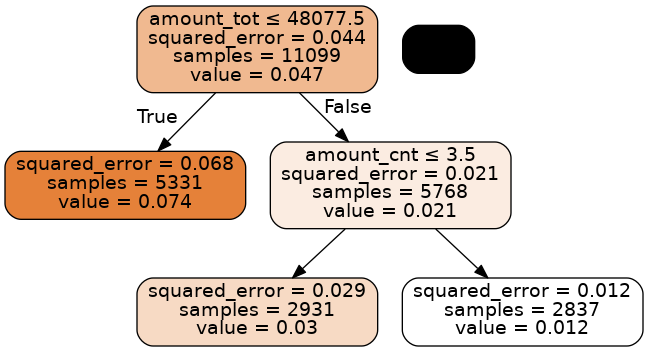

In [123]:
import pydotplus
from IPython.display import Image
from six import StringIO
import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#with open("dt.dot", "w") as f:
#    tree.export_graphviz(dtree, out_file=f)
dot_data = StringIO()
tree.export_graphviz(
    dtree, 
    out_file=dot_data,
    feature_names=x.columns,
    class_names=['bad_ind'],
    filled=True, 
    rounded=True,
    special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [126]:
'''
利用结果划分用户
- 如果拒绝past_C类客户，则可以使整体负样本占比下降至0.021
- 如果将past_B也拒绝掉，则可以使整体负样本占比下降至0.012
- 至于实际对past_A、past_B、past_C采取何种策略，要根据利率来做线性规划，从而实现风险定价
'''
group_1 = fn.loc[(fn.amount_tot>48077.5)&(fn.amount_cnt>3.5)].copy()
group_1['level'] = 'past_A'
group_2 = fn.loc[(fn.amount_tot>48077.5)&(fn.amount_cnt<=3.5)].copy()
group_2['level'] = 'past_B'
group_3 = fn.loc[fn.amount_tot<=48077.5].copy()
group_3['level'] = 'past_C'
